In [8]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

# Plotting


In [20]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


def print_weights(model):
    for li, layer in enumerate(model.layers):
        print(f"Layer {li+1}:")
        for ni, neuron in enumerate(layer.neurons):
            w_vals = [round(w.data, 4) for w in neuron.w]   # round for readability
            b_val = round(neuron.b.data, 4)
            print(f"  Neuron {ni+1}: w={w_vals}, b={b_val}")

## VALUE CLASS
1. Added log
2. Added Relu


In [10]:
# --- Complete Value Class (Provided) ---
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __neg__(self): # -self
        return self * -1

  def __radd__(self, other): # other + self
      return self + other

  def __sub__(self, other): # self - other
      return self + (-other)

  def __rsub__(self, other): # other - self
      return other + (-self)

  def __rmul__(self, other): # other * self
      return self * other

  def __truediv__(self, other): # self / other
      return self * other**-1

  def __rtruediv__(self, other): # other / self
      return other * self**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def sigmoid(self):
    x = self.data
    t = 1.0 / (1.0 + math.exp(-x))
    out = Value(t, (self, ), 'sigmoid')
    
    def _backward():
      self.grad += t * (1-t) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  ###################
  def log(self) :
     eps = 1e-8
     x = self.data 
     x = max (x,eps)                        #to prevent log 0
     out = Value(math.log(x),(self, ),'log')

     def _backward():
        self.grad += (1/x) * out.grad
      
     out._backward = _backward
     return out
  
  def Relu(self) :
     x = self.data 
     relu = max (0,x)                   #turns negatives to 0
     out = Value(relu, (self,) , "ReLU")

     def _backward() :
        deriv = 0 if x <= 0 else 1
        self.grad = deriv * out.grad
      
     out._backward = _backward
     return out
  
  ####################
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


## Building a Neural Network
1. Added Kaiming (He)

In [11]:
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
  # TASK 3.1: Complete the Neuron class.
  def __init__(self, nin):
    self.fan_in = nin
    #Best for relu
    self.w = []
    limit = math.sqrt(2.0 / self.fan_in)
    self.w = [Value(random.uniform(-limit,limit)) for _ in range (self.fan_in)]
    self.b = Value(0) #set bias to 0


  def __call__(self, x):
    act = sum((wi * xi for wi,xi in zip(self.w,x)), self.b)
    return act.Relu()


  
  def parameters(self):
    return self.w + [self.b]

class Layer(Module):
  # TASK 3.2: Complete the Layer class.
  def __init__(self, nin, nout , p = 0.2):
    # A layer is a list of neurons.
    self.neurons = [Neuron(nin) for _ in range(nout)]
    self.probability = p  
  
  def __call__(self, x , training = True):
    # When you call a layer, you call each neuron with the input x.
    # outs = list of neuron outputs
    # return outs[0] if len(outs) == 1 else outs
    outs = []
    for neuron in self.neurons :
       outs.append(neuron(x))

    if training :
       dropped_n = []
       for out in outs :
          if random.random() < self.probability : #dropped neuron
             dropped_n.append(Value(0))   

          else :
             dropped_n.append(out * (1 / (1 - self.probability)))
        
       outs = dropped_n   #scaled on neurons and 0 for off neurons
             
    return outs[0] if len(outs) == 1 else outs       
       
  
  def parameters(self):
    # A layer's parameters are all the parameters from all its neurons.
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP(Module):
  # TASK 3.3: Complete the MLP class.
  def __init__(self, nin, nouts , p=0.2):
    # 'nouts' is a list of layer sizes.
    # e.g., MLP(3, [4, 4, 1]) is a network with 3 inputs, two hidden layers of 4 neurons, and one output neuron.
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    pass
  
  def __call__(self, x , training = True):
    # Pass the input 'x' through all the layers sequentially.
    # TODO: Implement the forward pass through all layers.
    for layer in self.layers :
       x = layer(x , training=training)             #feeed the result of each layer to the next one
       
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


## Part 5: Capstone Project - Handwritten Digit Recognition


### 5.1 Loading and Preparing the Data


In [12]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1)) # Flatten images to 64-element vectors

X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.2, shuffle=True, random_state=42
)

# Normalize pixel values to be between 0 and 1
X_train /= 16.0
X_test /= 16.0

# One-hot encode the labels
def one_hot_encode(y, num_classes):
    one_hot = np.zeros((len(y), num_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

num_classes = 10
y_train_one_hot = one_hot_encode(y_train, num_classes)

print(f"Training data shape: {X_train.shape}") # 1437 samples, 64 features each
print(f"Test data shape: {X_test.shape}")   # 360 samples, 64 features each

Training data shape: (1437, 64)
Test data shape: (360, 64)


### 5.2 Building and Training the Digit Recognizer
1. Added softmax

In [18]:
# Helper function for batching (provided)
def create_batches(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X), batch_size):
        end_idx = min(start_idx + batch_size, len(X))
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

def softmax(values) :
    exps = [v.exp() for v in values] 
    sum_exps = sum(exps,Value(0))

    return [v/ sum_exps for v in exps] 

def cosine_lr(epoch, total_epochs, lr_max, lr_min=1e-4):
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / total_epochs))


# Training
1. entropy loss
2. Momentum

## Tunning

In [14]:
learning_rates = [0.2,0.1,0.05,0.01,0.001]
batch_sizes = [64]
betas = [0.9,0.95,0.8]
epochs = [6,10]

best_config = None
best_loss = float("inf")

best_acc_config = None
best_acc = 0.0


for lr_init in learning_rates:
    for batch_size in batch_sizes:
        for n_epochs in epochs :
            for beta in betas :
            

                # fresh model each run
                neural_network = MLP(64, [32, 10])
                velocities = {p: 0.0 for p in neural_network.parameters()}

                lr = lr_init
                prev_epoch_loss = 0
                minimum_learning = 0.1
                total_loss = 0

                for epoch in range(n_epochs):
                    epoch_loss = 0

                    for X_batch, y_batch in create_batches(X_train, y_train_one_hot, batch_size):
                        inputs = [list(map(Value, xrow)) for xrow in X_batch]
                        logits_batch = [neural_network(x, training=True) for x in inputs]
                        ypred_batch = [softmax(logits) for logits in logits_batch]

                        true_labels = [list(map(Value, yrow)) for yrow in y_batch]

                        # Cross entropy loss
                        loss = sum(
                            -(yt * yp.log())
                            for ytrue, ypred in zip(true_labels, ypred_batch)
                            for yt, yp in zip(ytrue, ypred)
                        ) / len(X_batch)

                        # Zero gradients
                        for parameter in neural_network.parameters():
                            parameter.grad = 0
                        loss.backward()

                        # Momentum update
                        for parameter in neural_network.parameters():
                            velocity = velocities[parameter]
                            velocity = (beta * velocity) + parameter.grad
                            velocities[parameter] = velocity
                            parameter.data -= lr * velocity

                        epoch_loss += loss.data

                    # Early stop if loss stagnates
                    if abs(epoch_loss - prev_epoch_loss) <= 0.005:
                        break
                    prev_epoch_loss = epoch_loss

                    lr *= 0.95
                    total_loss = epoch_loss / (len(X_train) / batch_size)

                # ---- Evaluate on test set ----
                correct = 0
                total = len(X_test)
                inputs = [list(map(Value, xrow)) for xrow in X_test]

                for i in range(total):
                    outputs = neural_network(inputs[i], training=False)
                    predicted_class = np.argmax([p.data for p in outputs])
                    if predicted_class == y_test[i]:
                        correct += 1
                accuracy = correct / total

                print(f"lr={lr_init}, batch={batch_size}, beta={beta}, epochs={n_epochs} -> loss={total_loss:.4f}, acc={accuracy*100:.2f}%")

                # Track best loss
                if total_loss < best_loss:
                    best_loss = total_loss
                    best_loss_config = (lr_init, batch_size, beta, n_epochs)

                # Track best accuracy
                if accuracy > best_acc:
                    best_acc = accuracy
                    best_acc_config = (lr_init, batch_size, beta, n_epochs)

print("\nBest loss config:", best_loss_config, "with loss:", best_loss)
print("Best accuracy config:", best_acc_config, f"with accuracy: {best_acc*100:.2f}%")




lr=0.2, batch=64, beta=0.9, epochs=6 -> loss=0.7976, acc=94.44%
lr=0.2, batch=64, beta=0.95, epochs=6 -> loss=0.9967, acc=87.78%
lr=0.2, batch=64, beta=0.8, epochs=6 -> loss=0.8019, acc=96.11%
lr=0.2, batch=64, beta=0.9, epochs=10 -> loss=0.6448, acc=95.56%
lr=0.2, batch=64, beta=0.95, epochs=10 -> loss=1.5872, acc=53.89%
lr=0.2, batch=64, beta=0.8, epochs=10 -> loss=0.7395, acc=96.39%
lr=0.1, batch=64, beta=0.9, epochs=6 -> loss=0.8663, acc=95.28%
lr=0.1, batch=64, beta=0.95, epochs=6 -> loss=0.8067, acc=95.28%
lr=0.1, batch=64, beta=0.8, epochs=6 -> loss=0.8890, acc=95.28%
lr=0.1, batch=64, beta=0.9, epochs=10 -> loss=0.7534, acc=97.50%
lr=0.1, batch=64, beta=0.95, epochs=10 -> loss=0.9127, acc=95.28%
lr=0.1, batch=64, beta=0.8, epochs=10 -> loss=0.7765, acc=95.56%
lr=0.05, batch=64, beta=0.9, epochs=6 -> loss=1.3604, acc=67.78%
lr=0.05, batch=64, beta=0.95, epochs=6 -> loss=1.1514, acc=81.39%
lr=0.05, batch=64, beta=0.8, epochs=6 -> loss=1.6005, acc=59.44%
lr=0.05, batch=64, beta=0.

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x70c5a730dfd0>>
Traceback (most recent call last):
  File "/home/hodhod/miniconda3/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


lr=0.001, batch=64, beta=0.9, epochs=6 -> loss=2.2992, acc=25.56%
lr=0.001, batch=64, beta=0.95, epochs=6 -> loss=2.2982, acc=32.78%
lr=0.001, batch=64, beta=0.8, epochs=6 -> loss=2.3594, acc=7.78%
lr=0.001, batch=64, beta=0.9, epochs=10 -> loss=2.2470, acc=38.33%
lr=0.001, batch=64, beta=0.95, epochs=10 -> loss=2.2540, acc=33.61%
lr=0.001, batch=64, beta=0.8, epochs=10 -> loss=2.3021, acc=32.22%

Best loss config: (0.2, 64, 0.9, 10) with loss: 0.6447675924179266
Best accuracy config: (0.1, 64, 0.9, 10) with accuracy: 97.50%


In [ ]:
"""
I transfered this here so i can play this block individually, keeping the weights that the tunning operated on
"""
# Network architecture: 64 inputs -> 32 neuron hidden layer -> 10 output neurons
# You can try changing the architecture, but this is a good starting point.
neural_network = MLP(64, [32, 10])
print(f"Number of parameters: {len(neural_network.parameters())}")



# TASK 5.1: Complete the training loop for the digit recognizer.
#decreased learning rate , increased batch size and n_epochs to experiment
#losses kept same values due to big learning rate (1) , exploding
lr = 0.2
batch_size = 64
n_epochs = 10
beta = 0.9
velocities = {p : 0.0 for p in neural_network.parameters()} #initialzing to zero


learning = True 
minimum_learning = 0.005


prev_epoch_loss = 0 
for epoch in range(n_epochs):
    epoch_loss = 0
    
    for X_batch, y_batch in create_batches(X_train, y_train_one_hot, batch_size):
        
        # 1. Forward Pass
        # TODO: Get predictions for each sample in the batch
        # Note: The network expects inputs as lists of Value objects
        inputs = [list(map(Value, xrow)) for xrow in X_batch]
        logits_batch = [neural_network(x, training= True) for x in inputs]
        ypred_batch = [softmax(logits) for logits in logits_batch ]

        # 2. Compute Loss for the batch
        # TODO: Calculate the MSE loss for the batch
        # The true labels `y_batch` also need to be converted to Value objects for the subtraction
        true_lables = [list(map(Value,yrow)) for yrow in y_batch]
        
        loss = sum(
        -(yt * yp.log())
        for ytrue, ypred in zip(true_lables, ypred_batch)
        for yt, yp in zip(ytrue, ypred)
        ) / len(X_batch)                                #to compare between different batch sizes
        
        # 3. Backward Pass
        # TODO: Zero gradients and backpropagate
        for parameter in neural_network.parameters():
             parameter.grad = 0 
        loss.backward()

        #momentum
        for parameter in neural_network.parameters():
             velocity = velocities[parameter]
             velocity = (beta * velocity) + parameter.grad
             velocities[parameter] = velocity
             parameter.data -= lr * velocity

        epoch_loss += loss.data
    if abs(epoch_loss - prev_epoch_loss) < minimum_learning :
        break 
    prev_epoch_loss = epoch_loss


    print(f"Epoch {epoch + 1}, Average Loss: {epoch_loss / (len(X_train)/batch_size):.4f}")
    # Decrease learning rate over time
    lr *= 0.95  #stablizes training

Number of parameters: 2410


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x70c5a730dfd0>>
Traceback (most recent call last):
  File "/home/hodhod/miniconda3/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Epoch 1, Average Loss: 2.2477


### 5.3 Evaluating the Network

Let's see how well our trained model performs on the test set!

*(Evaluation code is provided for you)*

In [21]:
def evaluate_model(model, X_test, y_test):
    correct = 0
    total = len(X_test)
    
    inputs = [list(map(Value, xrow)) for xrow in X_test]
    
    for i in range(total):
        # Get prediction from the network
        outputs = model(inputs[i] , training = False)
        predicted_class = np.argmax([p.data for p in outputs])
        
        if predicted_class == y_test[i]:
            correct += 1
    
    accuracy = correct / total
    print(f"\nTest Accuracy: {accuracy * 100:.2f}%\n")
    print_weights(neural_network)


evaluate_model(neural_network, X_test, y_test)


Test Accuracy: 88.06%

Layer 1:
  Neuron 1: w=[np.float64(0.0102), np.float64(0.0873), np.float64(-0.0117), np.float64(0.219), np.float64(-0.1304), np.float64(-0.0808), np.float64(-0.1117), np.float64(0.0739), np.float64(0.1428), np.float64(0.0256), np.float64(-0.2564), np.float64(-0.0878), np.float64(0.1067), np.float64(-0.1169), np.float64(0.007), np.float64(0.1225), np.float64(-0.0222), np.float64(-0.0357), np.float64(0.0385), np.float64(0.191), np.float64(0.2584), np.float64(-0.14), np.float64(-0.1203), np.float64(-0.0629), np.float64(0.0657), np.float64(0.0122), np.float64(-0.0177), np.float64(0.3144), np.float64(0.1728), np.float64(-0.1968), np.float64(0.1021), np.float64(0.0041), np.float64(-0.0053), np.float64(-0.0898), np.float64(0.0515), np.float64(0.1749), np.float64(0.0924), np.float64(-0.0774), np.float64(-0.1101), np.float64(-0.044), np.float64(-0.0644), np.float64(-0.0548), np.float64(-0.0279), np.float64(0.1101), np.float64(0.0542), np.float64(-0.2015), np.float64(-0.2

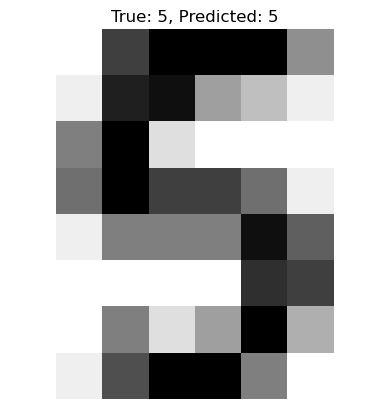

In [ ]:
def show_sample_with_output(model, X_test, y_test, sample_index):
    sample = X_test[sample_index]
    true_class = y_test[sample_index]
    
    input_value = list(map(Value, sample))
    outputs = model(input_value)
    predicted_class = np.argmax([p.data for p in outputs])

    plt.imshow(sample.reshape(8, 8), cmap=plt.cm.gray_r)
    plt.title(f"True: {true_class}, Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

# Show a random sample from the test set
show_sample_with_output(neural_network, X_test, y_test, sample_index=random.randint(0, X_test.shape[0]-1))

## Part 6: Putting It All Together with PyTorch

You've done the hard work. You've built an entire automatic differentiation engine and neural network library from scratch. Now, let's see how modern deep learning frameworks like **PyTorch** allow us to do the same thing with much less code.

This final task is to solve the same handwritten digit recognition problem, but this time using the tools provided by PyTorch. You will notice many parallels to the `Module`, `Layer`, and `Value` objects you created.

First, you'll need to install PyTorch if you haven't already:

In [ ]:
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


### 6.1 Data Preparation with PyTorch

PyTorch has its own data structures for handling data and creating batches efficiently. The first step is to convert our NumPy arrays into PyTorch `Tensors`.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# TASK 6.1: Convert data to PyTorch Tensors and create DataLoaders.

# --- Prepare the training data ---
# 1. Convert training features and labels from NumPy arrays to PyTorch Tensors.
#    Use torch.from_numpy(). Remember to convert them to the correct data type (.float() for features, .long() for labels).
X_train_tensor = torch.from_numpy(X_train).float() # TODO
y_train_tensor = torch.from_numpy(y_train).long() # TODO

# 2. Create a TensorDataset to bundle features and labels together.
train_dataset = TensorDataset(X_train_tensor , y_train_tensor)


# 3. Create a DataLoader to handle batching and shuffling automatically.
batch_size = 32
train_loader = DataLoader(train_dataset,shuffle = True ,batch_size=batch_size) # TODO


# --- Prepare the testing data ---
# 4. Do the same for the test set.
X_test_tensor = torch.from_numpy(X_test).float() # TODO
y_test_tensor = torch.from_numpy(y_test).long() # TODO
test_dataset = TensorDataset(X_test_tensor, y_test_tensor) # TODO
test_loader = DataLoader(test_dataset , batch_size = batch_size , shuffle = False) # TODO


# Let's check a batch to see what the DataLoader gives us
data_batch, labels_batch = next(iter(train_loader))
print(f"Data batch shape: {data_batch.shape}")
print(f"Labels batch shape: {labels_batch.shape}")

Data batch shape: torch.Size([32, 64])
Labels batch shape: torch.Size([32])


### 6.2 Building the Model in PyTorch

In PyTorch, models are created by creating a class that inherits from `nn.Module`. This is the direct equivalent of the `Module` class you built. Layers like `nn.Linear` are PyTorch's version of your `Layer` class, with weights and biases built-in.


In [ ]:
# TASK 6.2: Define the neural network architecture using nn.Module.

class MLP_PyTorch(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the layers of the network. Our network has:
        # 1. A linear layer from 64 inputs to 32 outputs.
        # 2. A ReLU activation function.
        # 3. A final linear layer from 32 inputs to 10 outputs (for the 10 digits).
        # You can try changing the architecture, but this is a good starting point.
        # TODO: Define the layers as class attributes (e.g., self.layer1 = nn.Linear(...))
        self.layer1 = nn.Linear(64,32)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(32,10)

    def forward(self, x):
        # This function defines the forward pass, just like your __call__ method.
        # TODO: Pass the input 'x' through the layers you defined in __init__.
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x

# Instantiate the model
model = MLP_PyTorch()
print(model)

MLP_PyTorch(
  (layer1): Linear(in_features=64, out_features=32, bias=True)
  (activation): ReLU()
  (layer2): Linear(in_features=32, out_features=10, bias=True)
)


### 6.3 Defining the Loss and Optimizer

PyTorch provides standard loss functions and optimizers. For this multi-class classification problem, `CrossEntropyLoss` is the best choice (it conveniently includes the Softmax layer for you). We'll use the Adam optimizer, which is a popular and effective choice.

In [ ]:
# TASK 6.3: Instantiate the loss function and optimizer.

# 1. The loss function for multi-class classification.
criterion = nn.CrossEntropyLoss() # TODO: Use nn.CrossEntropyLoss()

# 2. The optimizer that will update our model's parameters.
#    It needs to know which parameters to optimize (model.parameters()).
learning_rate = 0.0008
optimizer = optim.Adam(model.parameters() ,lr=lr) # TODO: Use optim.AdamW() and pass it the model's parameters and the learning rate.

### 6.4 The Training Loop in PyTorch

The training loop in PyTorch follows a standard, clean pattern. Compare this to the loop you wrote from scratch!

In [ ]:
# TASK 6.4: Complete the PyTorch training loop.

n_epochs = 15

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        # The standard 5-step PyTorch training process:

        # 1. Zero the gradients from the previous iteration.
        optimizer.zero_grad()
        
        # 2. Perform the forward pass to get model predictions.
        outputs = model(X_batch)

        # 3. Calculate the loss.
        loss = criterion(outputs, y_batch)

        # 4. Perform the backward pass to compute gradients.
        loss.backward()
        
        # 5. Update the model's weights.
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

print("Training finished!")

Epoch 1/15, Loss: 1.3719
Epoch 2/15, Loss: 0.7159
Epoch 3/15, Loss: 0.5654
Epoch 4/15, Loss: 0.4334
Epoch 5/15, Loss: 0.4025
Epoch 6/15, Loss: 0.3650
Epoch 7/15, Loss: 0.2988
Epoch 8/15, Loss: 0.3433
Epoch 9/15, Loss: 0.2709
Epoch 10/15, Loss: 0.3520
Epoch 11/15, Loss: 0.2773
Epoch 12/15, Loss: 0.3469
Epoch 13/15, Loss: 0.3314
Epoch 14/15, Loss: 0.3637
Epoch 15/15, Loss: 0.5490
Training finished!


### 6.5 Evaluating the PyTorch Model

Finally, let's see how our new model performs on the test set. The evaluation loop is similar, but we tell PyTorch not to calculate gradients to save time and memory.

*(This code is provided for you)*

In [ ]:
# Set the model to evaluation mode
model.eval()

correct = 0
total = 0

# Tell PyTorch not to track gradients during evaluation
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Get predictions
        outputs = model(X_batch)
        
        # The class with the highest value is our prediction
        _, predicted = torch.max(outputs.data, 1)
        
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f'\nAccuracy of the network on the test images: {accuracy:.2f} %')


Accuracy of the network on the test images: 78.06 %
